In [22]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix

# deep learning libraries
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from keras.preprocessing import image

import cv2

import warnings
warnings.filterwarnings('ignore')


In [24]:
train_path="/kaggle/input/isl-dataset/isl_data_grey_split/train"
test_path="/kaggle/input/isl-dataset/isl_data_grey_split/test"
labels=os.listdir(train_path)
class_names_test=os.listdir(test_path)

In [26]:
print(labels)
print(class_names_test)

[23  7 27  2 11 18 15 17  5 14 30 22  8 33  0 20 26 34 28 16 10 24 29 31
 35  3  1 12  4 25  9 21  6 32 13 19]
['n', '7', 'r', '2', 'b', 'i', 'f', 'h', '5', 'e', 'u', 'm', '8', 'x', '0', 'k', 'q', 'y', 's', 'g', 'a', 'o', 't', 'v', 'z', '3', '1', 'c', '4', 'p', '9', 'l', '6', 'w', 'd', 'j']


In [27]:
train_datagen = ImageDataGenerator(zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15)
test_datagen = ImageDataGenerator(zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15)

In [30]:
gen = ImageDataGenerator(
                  rescale=1./255.,
                  horizontal_flip = True,
                  validation_split=0.2 # training: 80% data, validation: 20% data
                 )

In [43]:
train_generator = gen.flow_from_directory(train_path,subset="training",target_size=(331, 331),batch_size=32,shuffle=True,class_mode='categorical')
validation_generator = gen.flow_from_directory(train_path,subset="validation",target_size=(331,331),batch_size=32,shuffle=True,class_mode='categorical')

Found 15587 images belonging to 36 classes.
Found 3896 images belonging to 36 classes.


In [44]:
x,y = next(train_generator)
x.shape 


(32, 331, 331, 3)

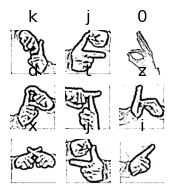

In [46]:
a = train_generator.class_indices
class_names = list(a.keys()) # storing class/breed names in a list


def plot_images(img, labels):
    plt.figure(figsize=[2, 2])
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(img[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')

plot_images(x,y)


In [57]:
# load the InceptionResNetV2 architecture with imagenet weights as base
base_model = tf.keras.applications.InceptionResNetV2(
					include_top=False,
					weights='imagenet',
					input_shape=(331,331,3)
					)

base_model.trainable=False
# For freezing the layer we make use of layer.trainable = False
# means that its internal state will not change during training.
# model's trainable weights will not be updated during fit(),
# and also its state updates will not run.

model = tf.keras.Sequential([
		base_model,
		tf.keras.layers.BatchNormalization(renorm=True),
		tf.keras.layers.GlobalAveragePooling2D(),
		tf.keras.layers.Dense(512, activation='relu'),
		tf.keras.layers.Dense(256, activation='relu'),
		tf.keras.layers.Dropout(0.5),
		tf.keras.layers.Dense(128, activation='relu'),
		tf.keras.layers.Dense(36, activation='softmax')
	])


In [58]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# categorical cross entropy is taken since its used as a loss function for
# multi-class classification problems where there are two or more output labels.
# using Adam optimizer for better performance
# other optimizers such as sgd can also be used depending upon the model


In [59]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 9, 9, 1536)       54336736  
 onal)                                                           
                                                                 
 batch_normalization_407 (Ba  (None, 9, 9, 1536)       10752     
 tchNormalization)                                               
                                                                 
 global_average_pooling2d_1   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 512)               786944    
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                      

In [60]:
early = tf.keras.callbacks.EarlyStopping( patience=10,
										min_delta=0.001,
										restore_best_weights=True)
# early stopping call back


In [61]:
batch_size=32
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size

# fit model
history = model.fit(train_generator,
                    verbose= 1,
					steps_per_epoch=STEP_SIZE_TRAIN,
					validation_data=validation_generator,
					validation_steps=STEP_SIZE_VALID,
					epochs=25,
					callbacks=[early])


Epoch 1/25
487/487 [==============================] - 275s 540ms/step - loss: 0.5727 - accuracy: 0.8363 - val_loss: 0.0694 - val_accuracy: 0.9760
Epoch 2/25
487/487 [==============================] - 138s 284ms/step - loss: 0.0728 - accuracy: 0.9776 - val_loss: 0.0584 - val_accuracy: 0.9819
Epoch 3/25
487/487 [==============================] - 153s 314ms/step - loss: 0.0393 - accuracy: 0.9875 - val_loss: 0.0296 - val_accuracy: 0.9920
Epoch 4/25
487/487 [==============================] - 152s 312ms/step - loss: 0.0392 - accuracy: 0.9887 - val_loss: 0.0314 - val_accuracy: 0.9920
Epoch 5/25
487/487 [==============================] - 139s 284ms/step - loss: 0.0358 - accuracy: 0.9898 - val_loss: 0.0263 - val_accuracy: 0.9917
Epoch 6/25
487/487 [==============================] - 152s 312ms/step - loss: 0.0305 - accuracy: 0.9916 - val_loss: 0.0980 - val_accuracy: 0.9830
Epoch 7/25
487/487 [==============================] - 139s 285ms/step - loss: 0.0240 - accuracy: 0.9933 - val_loss: 0.0399 -

Text(0.5, 1.0, '\nTraining and Validation Accuracy. \nTrain Accuracy:0.9973641633987427\nValidation Accuracy: 0.9912189841270447')

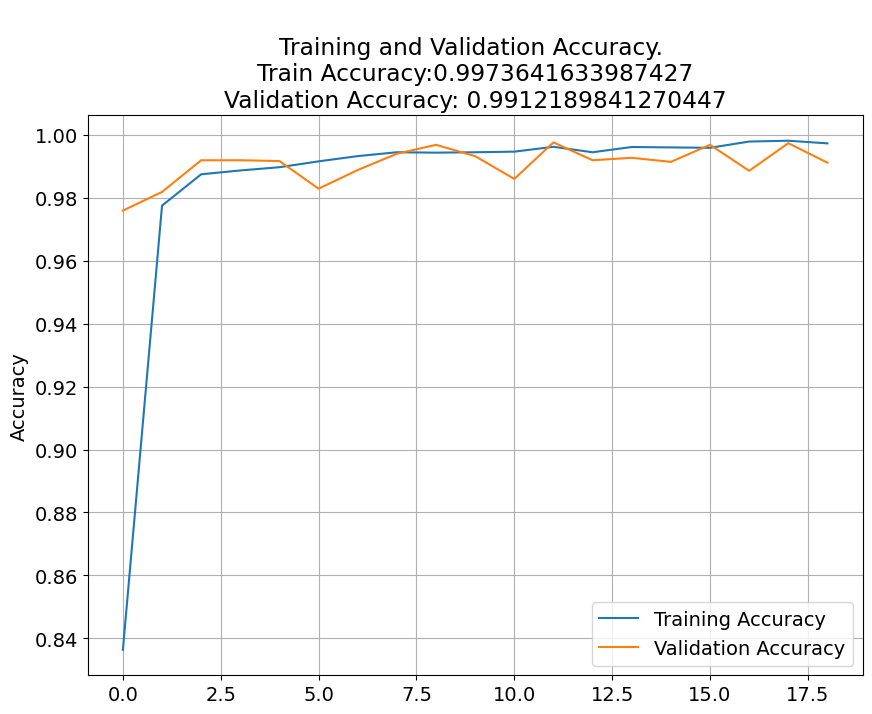

In [63]:
# store results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


# plot results
# accuracy
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy:{str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')


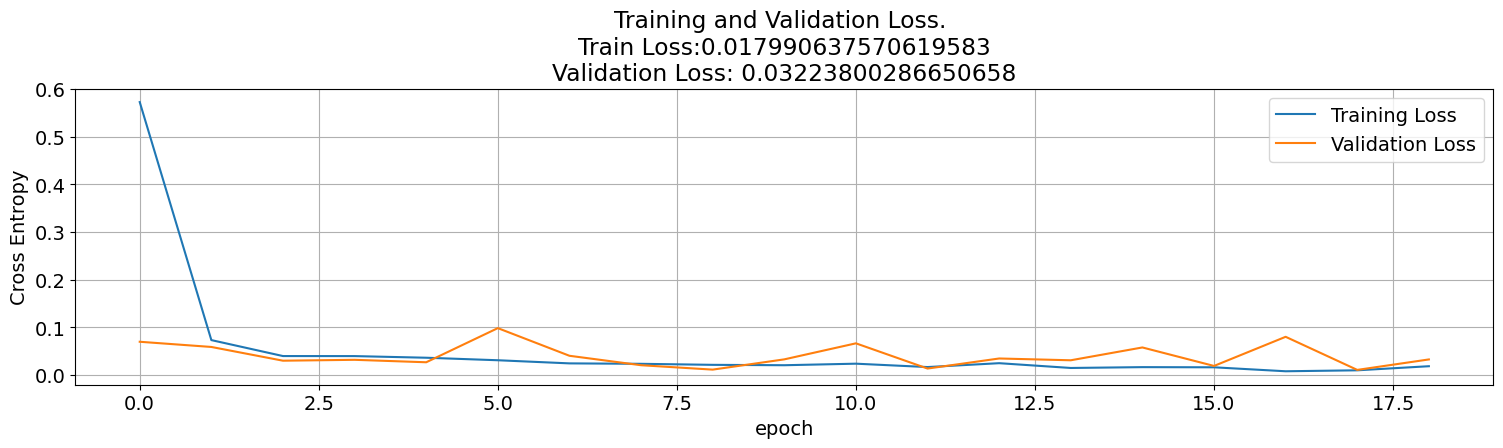

In [65]:
# loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss:{str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()


In [66]:
accuracy_score = model.evaluate(validation_generator)
print(accuracy_score)
print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100))

print("Loss: ",accuracy_score[0])


122/122 [==============================] - 28s 231ms/step - loss: 0.0120 - accuracy: 0.9972
[0.011955160647630692, 0.9971765875816345]
Accuracy: 99.7177%
Loss:  0.011955160647630692
